<a href="https://colab.research.google.com/github/AxelMAO/AIF/blob/main/rec_sys/recommender_systems/INSA_Reco.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this practical session, you will implement different strategies to build a recommender system.

# Dataset



We will be utilizing 'The Movie Dataset' hosted on Kaggle, featuring comprehensive metadata for 45,000 movies listed in the Full MovieLens Dataset (accessible here: [Full MovieLens Dataset](https://grouplens.org/datasets/movielens/)). The dataset encompasses films released up until July 2017 and includes a variety of data points such as cast, crew, plot keywords, budget, revenue, posters, release dates, languages, production companies, countries, as well as TMDB vote counts and vote averages.

Additionally, this dataset encompasses 26 million ratings from 270,000 users across all 45,000 movies. These ratings, ranging from 1 to 5, are sourced directly from the official GroupLens website.

To access this dataset, a [Kaggle](https://www.kaggle.com/) account is required. After logging into Kaggle, navigate to your account settings and scroll to the API section to generate a new API token. This token will facilitate the direct download of the dataset via the Kaggle library in your notebook.

![Instructions for generating a Kaggle API token](https://drive.google.com/uc?export=view&id=1YcSTHD_FGrwDKaaLk6T9Gsdte8TKuPCt)

Now, you can proceed to install the Kaggle library in your notebook, which allows for the dataset to be downloaded directly.


In [2]:
!pip install kaggle

Run the next cell to upload your token.

In [3]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 66 bytes


We will begin by analyzing the metadata dataset, which includes comprehensive information about the movies.  
This dataset encompasses details such as movie titles, descriptions, genres, and even their average IMDb ratings.

In [4]:
!kaggle datasets download "rounakbanik/the-movies-dataset" -f movies_metadata.csv
!kaggle datasets download "rounakbanik/the-movies-dataset" -f ratings.csv
!unzip movies_metadata.csv.zip
!unzip ratings.csv.zip

Dataset URL: https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset
License(s): CC0-1.0
movies_metadata.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
Dataset URL: https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset
License(s): CC0-1.0
ratings.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  movies_metadata.csv.zip
replace movies_metadata.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: movies_metadata.csv     
Archive:  ratings.csv.zip
replace ratings.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: ratings.csv             


Use pandas to explore the `movies_metadata.csv` dataset.


In [2]:
import pandas as pd
metadata = pd.read_csv('movies_metadata.csv')
metadata.dropna(subset=['title'], inplace=True)
metadata['id'] = pd.to_numeric(metadata['id'])
metadata['genres'] = metadata['genres'].apply(lambda x: [i['name'] for i in eval(x)])
metadata = metadata[['id', 'title', 'genres', 'release_date', 'vote_average', 'vote_count']]
metadata.head(5)

<ipython-input-2-8e2a9fc35ff1>:2: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv('movies_metadata.csv')


id                        title                        genres  \
0    862                    Toy Story   [Animation, Comedy, Family]   
1   8844                      Jumanji  [Adventure, Fantasy, Family]   
2  15602             Grumpier Old Men             [Romance, Comedy]   
3  31357            Waiting to Exhale      [Comedy, Drama, Romance]   
4  11862  Father of the Bride Part II                      [Comedy]   

  release_date  vote_average  vote_count  
0   1995-10-30           7.7      5415.0  
1   1995-12-15           6.9      2413.0  
2   1995-12-22           6.5        92.0  
3   1995-12-22           6.1        34.0  
4   1995-02-10           5.7       173.0

Using the release date, create a new column called `year` and use seaborn to plot the number of movies per year.

In [3]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

metadata['year'] = pd.to_datetime(metadata['release_date'], errors='coerce').apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)
metadata.head(5)

id                        title                        genres  \
0    862                    Toy Story   [Animation, Comedy, Family]   
1   8844                      Jumanji  [Adventure, Fantasy, Family]   
2  15602             Grumpier Old Men             [Romance, Comedy]   
3  31357            Waiting to Exhale      [Comedy, Drama, Romance]   
4  11862  Father of the Bride Part II                      [Comedy]   

  release_date  vote_average  vote_count  year  
0   1995-10-30           7.7      5415.0  1995  
1   1995-12-15           6.9      2413.0  1995  
2   1995-12-22           6.5        92.0  1995  
3   1995-12-22           6.1        34.0  1995  
4   1995-02-10           5.7       173.0  1995

<Axes: xlabel='year', ylabel='count'>

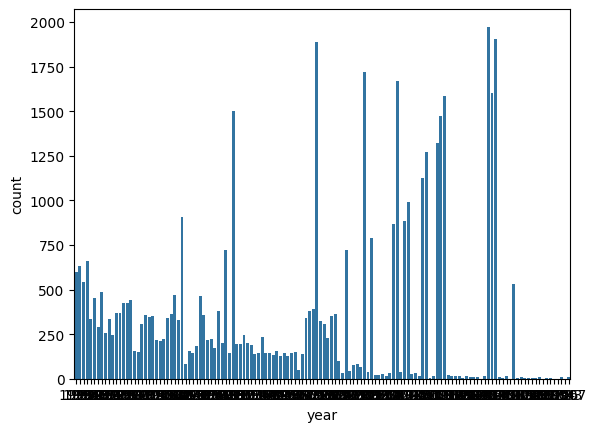

In [4]:
sns.countplot(x='year', data=metadata)

# Recommendation by popularity

Let's start with a straightforward approach to generating recommendations by suggesting the top 5 movies based on their average score. However, it's worth noting that while average score is a useful metric, it may not always provide the most personalized recommendations, as individual preferences can vary widely.

In [5]:
top_five_movies = metadata.sort_values(by='vote_average', ascending=False).head(5)
top_five_movies

id                                            title  \
21642  320849  Ice Age Columbus: Who Were the First Americans?   
15710   96451        If God Is Willing and da Creek Don't Rise   
22396   72123                                   Meat the Truth   
22395  230864            Marvin Hamlisch: What He Did For Love   
35343  140595                       Elaine Stritch: At Liberty   

                                       genres release_date  vote_average  \
21642                           [Documentary]   2005-01-01          10.0   
15710                           [Documentary]   2010-08-23          10.0   
22396                           [Documentary]   2008-10-03          10.0   
22395                           [Documentary]   2013-10-12          10.0   
35343  [Comedy, Documentary, Music, TV Movie]   2002-01-01          10.0   

       vote_count  year  
21642         1.0  2005  
15710         1.0  2010  
22396         1.0  2008  
22395         1.0  2013  
35343         1.0  2002

Have you seen any of these movies?  
You may have guessed that the average score is only reliable when it is averaged on a sufficient number of votes.
Use seaborn ```histplot``` method to plot the histogram of the number of votes.
For better readability you may first do this plot for the movies with less than 100 votes and then do another one for the remaining ones.

In [8]:
metadata_100 = metadata[metadata['vote_count'] > 100]
metadata_less_100 = metadata[metadata['vote_count'] <= 100]

<Axes: xlabel='vote_count', ylabel='Count'>

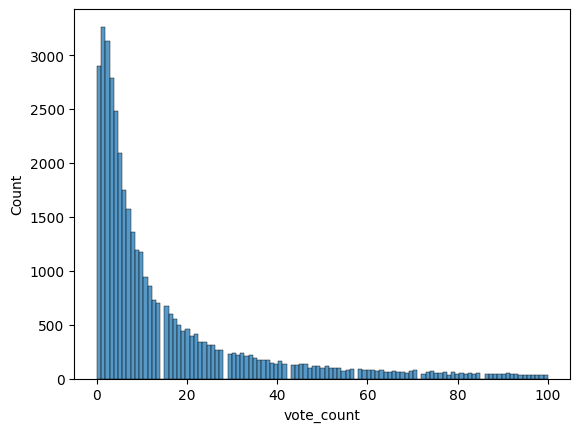

In [9]:
sns.histplot(data=metadata_less_100, x='vote_count')

<Axes: xlabel='vote_count', ylabel='Count'>

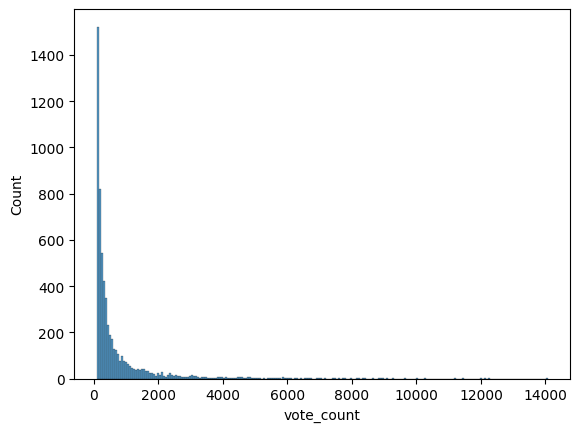

In [7]:
sns.histplot(data=metadata_100, x='vote_count')

Try to visualize the best movies according to the average vote for movies that have at least 1000 votes.  
You should now know some of these movies now.


In [10]:
top_five_movies_1000 = metadata[metadata['vote_count']>=1000].sort_values(by='vote_average', ascending=False).head(5)
top_five_movies_1000

id                        title                       genres  \
834       238                The Godfather               [Drama, Crime]   
40251  372058                   Your Name.  [Romance, Animation, Drama]   
314       278     The Shawshank Redemption               [Drama, Crime]   
292       680                 Pulp Fiction            [Thriller, Crime]   
1184      311  Once Upon a Time in America               [Drama, Crime]   

      release_date  vote_average  vote_count  year  
834     1972-03-14           8.5      6024.0  1972  
40251   2016-08-26           8.5      1030.0  2016  
314     1994-09-23           8.5      8358.0  1994  
292     1994-09-10           8.3      8670.0  1994  
1184    1984-02-16           8.3      1104.0  1984

## Best movies by IMDb score
IMDb (an acronym for Internet Movie Database) is an online database of information related to films, television programs, home videos, video games, and streaming content online.
It might be considered as one of the most exhaustive databases on movies.
In addition, IMDb maintains a ranking of movies according to people's votes. To do so, it computes a score based on the average rating and the number of votes.
The formula they are using is described [here](https://help.imdb.com/article/imdb/track-movies-tv/ratings-faq/G67Y87TFYYP6TWAV#)
![](https://drive.google.com/uc?export=view&id=12J_uJ86eOimr8Y0LHTGSMmUgkBnZu9cO)  
Use this formula to compute the IMDb score for all movies and visualize the ones with the best scores. (You may use a smaller value for m, 500 for example)


In [11]:
m = 500
c = metadata.vote_average.mean()

def imdb_score(x):
    v = x['vote_count']
    r = x['vote_average']
    return (v/(v+m) * r) + (m/(m+v) * c)

metadata['imdb_score'] = metadata.apply(imdb_score, axis=1)

What were the best movies in your birth year?

In [12]:
top_five_movies_imdb_2003 = metadata[metadata['year'] == '2003'].sort_values(by='imdb_score', ascending=False).head(5)
top_five_movies_imdb_2003

id                                              title  \
7000  122      The Lord of the Rings: The Return of the King   
9430  670                                             Oldboy   
6725   24                                  Kill Bill: Vol. 1   
6232   12                                       Finding Nemo   
6390   22  Pirates of the Caribbean: The Curse of the Bla...   

                                  genres release_date  vote_average  \
7000        [Adventure, Fantasy, Action]   2003-12-01           8.1   
9430  [Drama, Thriller, Mystery, Action]   2003-01-01           8.0   
6725                     [Action, Crime]   2003-10-10           7.7   
6232                 [Animation, Family]   2003-05-30           7.6   
6390        [Adventure, Fantasy, Action]   2003-07-09           7.5   

      vote_count  year  imdb_score  
7000      8226.0  2003    7.957793  
9430      2000.0  2003    7.523641  
6725      5091.0  2003    7.513826  
6232      6292.0  2003    7.454108  
6390      7191.0  2003    7.377663

In [16]:
top_movies_imdb = metadata.sort_values(by='imdb_score', ascending=False).head(5)
top_movies_imdb

id                     title                            genres  \
314    278  The Shawshank Redemption                    [Drama, Crime]   
834    238             The Godfather                    [Drama, Crime]   
12481  155           The Dark Knight  [Drama, Action, Crime, Thriller]   
2843   550                Fight Club                           [Drama]   
292    680              Pulp Fiction                 [Thriller, Crime]   

      release_date  vote_average  vote_count  year  imdb_score  
314     1994-09-23           8.5      8358.0  1994    8.337334  
834     1972-03-14           8.5      6024.0  1972    8.279139  
12481   2008-07-16           8.3     12269.0  2008    8.194988  
2843    1999-10-15           8.3      9678.0  1999    8.168255  
292     1994-09-10           8.3      8670.0  1994    8.153774

One way to refine recommendations is by considering popularity and recommending products from the same category or genre. This approach can help ensure that the suggestions are not only highly rated but also aligned with the user's interests.  
The following code will create a data frame containing one-hot encoding of the movie's genre.
Use it to recommend the best movies according to the genre and the IMDB score (for example the best Horror movies)

In [17]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
genre_df = pd.DataFrame(mlb.fit_transform(metadata['genres'].fillna('[]')),columns=mlb.classes_, index=metadata.index)
metadata = pd.concat([metadata.drop(columns=['genres']), genre_df], axis=1)
metadata.head()

id                        title release_date  vote_average  vote_count  \
0    862                    Toy Story   1995-10-30           7.7      5415.0   
1   8844                      Jumanji   1995-12-15           6.9      2413.0   
2  15602             Grumpier Old Men   1995-12-22           6.5        92.0   
3  31357            Waiting to Exhale   1995-12-22           6.1        34.0   
4  11862  Father of the Bride Part II   1995-02-10           5.7       173.0   

   year  imdb_score  Action  Adventure  Animation  ...  History  Horror  \
0  1995    7.524024       0          0          1  ...        0       0   
1  1995    6.679988       0          1          0  ...        0       0   
2  1995    5.755243       0          0          0  ...        0       0   
3  1995    5.648883       0          0          0  ...        0       0   
4  1995    5.639233       0          0          0  ...        0       0   

   Music  Mystery  Romance  Science Fiction  TV Movie  Thriller  War  Western  
0      0        0        0                0         0         0    0        0  
1      0        0        0                0         0         0    0        0  
2      0        0        1                0         0         0    0        0  
3      0        0        1                0         0         0    0        0  
4      0        0        0                0         0         0    0        0  

[5 rows x 27 columns]

Recommend some horror or comedy movies.

In [22]:
top_movies_horror_comedy = metadata[(metadata['Horror']==1) | (metadata['Comedy']==1)].sort_values(by='imdb_score', ascending=False).head(10)
top_movies_horror_comedy

id                     title release_date  vote_average  \
351        13              Forrest Gump   1994-07-06           8.2   
18465   77338          The Intouchables   2011-11-02           8.2   
2211      637         Life Is Beautiful   1997-12-20           8.3   
1176      539                    Psycho   1960-06-16           8.3   
1225      105        Back to the Future   1985-07-03           8.0   
1213      694               The Shining   1980-05-22           8.1   
22841  120467  The Grand Budapest Hotel   2014-02-26           8.0   
22131  106646   The Wolf of Wall Street   2013-12-25           7.9   
30315  150540                Inside Out   2015-06-09           7.9   
40882  313369                La La Land   2016-11-29           7.9   

       vote_count  year  imdb_score  Action  Adventure  Animation  ...  \
351        8147.0  1994    8.050712       0          0          0  ...   
18465      5410.0  2011    7.981574       0          0          0  ...   
2211       3643.0  1997    7.976347       0          0          0  ...   
1176       2405.0  1960    7.838418       0          0          0  ...   
1225       6239.0  1985    7.823283       0          1          0  ...   
1213       3890.0  1980    7.817336       0          0          0  ...   
22841      4644.0  2014    7.768488       0          0          0  ...   
22131      6768.0  2013    7.743025       0          0          0  ...   
30315      6737.0  2015    7.742352       0          0          1  ...   
40882      4745.0  2016    7.682479       0          0          0  ...   

       History  Horror  Music  Mystery  Romance  Science Fiction  TV Movie  \
351          0       0      0        0        1                0         0   
18465        0       0      0        0        0                0         0   
2211         0       0      0        0        0                0         0   
1176         0       1      0        0        0                0         0   
1225         0       0      0        0        0                1         0   
1213         0       1      0        0        0                0         0   
22841        0       0      0        0        0                0         0   
22131        0       0      0        0        0                0         0   
30315        0       0      0        0        0                0         0   
40882        0       0      1        0        1                0         0   

       Thriller  War  Western  
351           0    0        0  
18465         0    0        0  
2211          0    0        0  
1176          1    0        0  
1225          0    0        0  
1213          1    0        0  
22841         0    0        0  
22131         0    0        0  
30315         0    0        0  
40882         0    0        0  

[10 rows x 27 columns]

# Content based recommender systems


### Item description
An alternative approach to building a recommender system is to generate recommendations based on content characteristics. This method is particularly appealing when dealing with situations where there are limited user interactions or a scarcity of new items to recommend. It's highly probable that your catalog includes supplementary data related to the items. This additional information is typically curated manually and can contain valuable features for the development of a content-based recommender system.

In our specific case, we will obtain a dataset that includes keywords associated with the movies to facilitate this approach.

In [23]:
!kaggle datasets download "rounakbanik/the-movies-dataset" -f keywords.csv
!unzip keywords.csv.zip

Dataset URL: https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset
License(s): CC0-1.0
 72% 1.00M/1.39M [00:00<00:00, 6.80MB/s]
100% 1.39M/1.39M [00:00<00:00, 7.36MB/s]
Archive:  keywords.csv.zip
  inflating: keywords.csv            


In [24]:
keywords = pd.read_csv('keywords.csv')
keywords['keywords'] = keywords['keywords'].apply(lambda x: " ".join([i['name'] for i in eval(x)])).fillna('')
keywords.head()

id                                           keywords
0    862  jealousy toy boy friendship friends rivalry bo...
1   8844  board game disappearance based on children's b...
2  15602   fishing best friend duringcreditsstinger old men
3  31357  based on novel interracial relationship single...
4  11862  baby midlife crisis confidence aging daughter ...

These keywords can serve as excellent descriptors for our movies.  
To enable similarity calculations between movies, it's essential to represent them in a vectorized format.  
We will now create another dataframe containing all the movies attributes.

In [25]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

mlb = CountVectorizer(max_features=400)
keywords_transformed = mlb.fit_transform(keywords['keywords'])
keywords_transformed = pd.DataFrame(keywords_transformed.toarray(), columns=mlb.get_feature_names_out(), index=keywords.index)
keywords = pd.concat([keywords.drop(columns=['keywords']), keywords_transformed], axis=1)
keywords.head()

id  1970s  3d  abuse  accident  addiction  adult  adultery  affair  \
0    862      0   0      0         0          0      0         0       0   
1   8844      0   0      0         0          0      0         0       0   
2  15602      0   0      0         0          0      0         0       0   
3  31357      0   0      0         0          0      0         0       0   
4  11862      0   0      0         0          0      0         0       0   

   africa  ...  wife  witch  woman  women  world  writer  york  young  youth  \
0       0  ...     0      0      0      0      0       0     0      0      0   
1       0  ...     0      0      0      0      0       0     0      0      0   
2       0  ...     0      0      0      0      0       0     0      0      0   
3       0  ...     0      0      0      0      0       0     0      0      0   
4       0  ...     0      0      0      0      0       0     0      0      0   

   zombie  
0       0  
1       0  
2       0  
3       0  
4       0  

[5 rows x 401 columns]

We will proceed by constructing a dataframe in which each movie is depicted through its attribute vectors, encompassing keywords and genres.  
To optimize computational resources and reduce memory requirements, we will restrict our analysis to movies released after the year 2010.

In [26]:
subset = metadata[metadata['release_date'] > "2010"].reset_index(drop=True)

attributes_df = pd.merge(subset.drop(columns=['release_date', 'vote_average', 'vote_count', 'year',
       'imdb_score']), keywords, on='id')
attributes_df.head()

id                 title  Action  Adventure  Animation  Comedy  Crime  \
0   79782                Venice       0          0          0       0      0   
1  141210         The Sleepover       0          0          0       1      0   
2  143750     The Farmer's Wife       0          0          0       0      0   
3   84198  A Place at the Table       0          0          0       0      0   
4   84198  A Place at the Table       0          0          0       0      0   

   Documentary  Drama  Family  ...  wife  witch  woman  women  world  writer  \
0            0      1       0  ...     0      0      0      0      0       0   
1            0      0       0  ...     0      0      0      0      0       0   
2            0      1       0  ...     0      0      0      0      0       0   
3            1      0       0  ...     0      0      1      0      0       0   
4            1      0       0  ...     0      0      1      0      0       0   

   york  young  youth  zombie  
0     0      0      0       0  
1     0      0      0       0  
2     0      0      0       0  
3     0      0      0       0  
4     0      0      0       0  

[5 rows x 422 columns]

Now that you have a representation computed for each movie, you can calculate distances or similarities for movie pairs.  
Use scikit-learn 's [cosine_distances](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_distances.html) function, to compute the cosine similarity matrix of your dataframe.  

In [27]:
from sklearn.metrics.pairwise import cosine_distances
cosine_sim = cosine_distances(attributes_df.drop(columns=['id', 'title']))
cosine_sim.shape

(13289, 13289)

Use the following function with your similarity matrix to recommend movies from another movie title.  
Try on several movies.

In [28]:
titles = attributes_df['title']
indices = pd.Series(attributes_df.index, index=attributes_df['title'])

def get_reco(title, sim_matrix):
  idx = indices[title]
  print(f'original: {title}')
  recos = sim_matrix[idx].argsort()[1:6]
  recos = titles.iloc[recos]

  print(recos)

In [29]:
title = 'LEGO: The Adventures of Clutch Powers'
get_reco(title, cosine_sim)

original: LEGO: The Adventures of Clutch Powers
4380                                                Tarzan
11016                                               Trolls
7253     LEGO DC Comics Super Heroes: Justice League: A...
5129     LEGO DC Comics Super Heroes: Justice League vs...
11020    LEGO DC Comics Super Heroes: Batman: Be-Leaguered
Name: title, dtype: object


In [30]:
title = 'Iron Man 2'
get_reco(title, cosine_sim)

original: Iron Man 2
4548                                          Ant-Man
3143    Avengers Confidential: Black Widow & Punisher
6006        Iron Man & Captain America: Heroes United
4554                                   Doctor Strange
2618                             Thor: The Dark World
Name: title, dtype: object


In [32]:
title = 'How to Train Your Dragon'
get_reco(title, cosine_sim)

original: How to Train Your Dragon
193      Legend of the Guardians: The Owls of Ga'Hoole
10712                             Over the Garden Wall
6703                       Dragon Nest: Warriors' Dawn
4983                              The Gruffalo's Child
7484                        The Snow Queen 2: Refreeze
Name: title, dtype: object


In [33]:
title = 'Alice in Wonderland'
get_reco(title, cosine_sim)

original: Alice in Wonderland
9770                      Alice Through the Looking Glass
297     The Chronicles of Narnia: The Voyage of the Da...
2343                       Percy Jackson: Sea of Monsters
2119                                                 Epic
5209                                                  Pan
Name: title, dtype: object


Let's free some memory in the Colab instance.

In [36]:
del(cosine_sim)
del(attributes_df)

NameError: name 'cosine_sim' is not defined

### Images

Images are another type of content associated to products.  
It may not necessarily be relevant in the case of movies but let's do it anyway.  
We will now recommend movies according to their posters.  
First, we need to download another dataset.

In [31]:
!kaggle datasets download "ghrzarea/movielens-20m-posters-for-machine-learning"
!unzip movielens-20m-posters-for-machine-learning.zip

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: mlp-20m/MLP-20M/81566.jpg  
  inflating: mlp-20m/MLP-20M/81568.jpg  
  inflating: mlp-20m/MLP-20M/8157.jpg  
  inflating: mlp-20m/MLP-20M/81574.jpg  
  inflating: mlp-20m/MLP-20M/8158.jpg  
  inflating: mlp-20m/MLP-20M/81583.jpg  
  inflating: mlp-20m/MLP-20M/81585.jpg  
  inflating: mlp-20m/MLP-20M/81587.jpg  
  inflating: mlp-20m/MLP-20M/81589.jpg  
  inflating: mlp-20m/MLP-20M/81591.jpg  
  inflating: mlp-20m/MLP-20M/816.jpg  
  inflating: mlp-20m/MLP-20M/81610.jpg  
  inflating: mlp-20m/MLP-20M/81613.jpg  
  inflating: mlp-20m/MLP-20M/81615.jpg  
  inflating: mlp-20m/MLP-20M/81617.jpg  
  inflating: mlp-20m/MLP-20M/81621.jpg  
  inflating: mlp-20m/MLP-20M/81629.jpg  
  inflating: mlp-20m/MLP-20M/81631.jpg  
  inflating: mlp-20m/MLP-20M/81633.jpg  
  inflating: mlp-20m/MLP-20M/81637.jpg  
  inflating: mlp-20m/MLP-20M/81639.jpg  
  inflating: mlp-20m/MLP-20M/81641.jpg  
  inflating: mlp-20m/MLP

The following code will help loading the data with Pytorch.

In [37]:
import torch
from torchvision import datasets

class ImageAndPathsDataset(datasets.ImageFolder):
    def __getitem__(self, index):
        img, _= super(ImageAndPathsDataset, self).__getitem__(index)
        path = self.imgs[index][0]
        return img, path



We will use a pre-trained network to extract the features from the posters.
Similar to what we did with the item descriptions, we will compute similarities between the movies according to these features.

The pre-trained model was trained with normalized images. Thus, we have to normalize our posters before feeding them to the network.
The following code instantiates a data loader with normalized images and provides a function to revert the normalization for visualization purposes.


In [38]:
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

mean = [ 0.485, 0.456, 0.406 ]
std = [ 0.229, 0.224, 0.225 ]
normalize = transforms.Normalize(mean, std)
inv_normalize = transforms.Normalize(
   mean= [-m/s for m, s in zip(mean, std)],
   std= [1/s for s in std]
)

transform = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.ToTensor(),
                                normalize])
dataset = ImageAndPathsDataset('MLP-20M', transform)

dataloader = DataLoader(dataset, batch_size=128, num_workers=2, shuffle=False)

Here are some exemples of posters:

(-0.5, 1809.5, 453.5, -0.5)

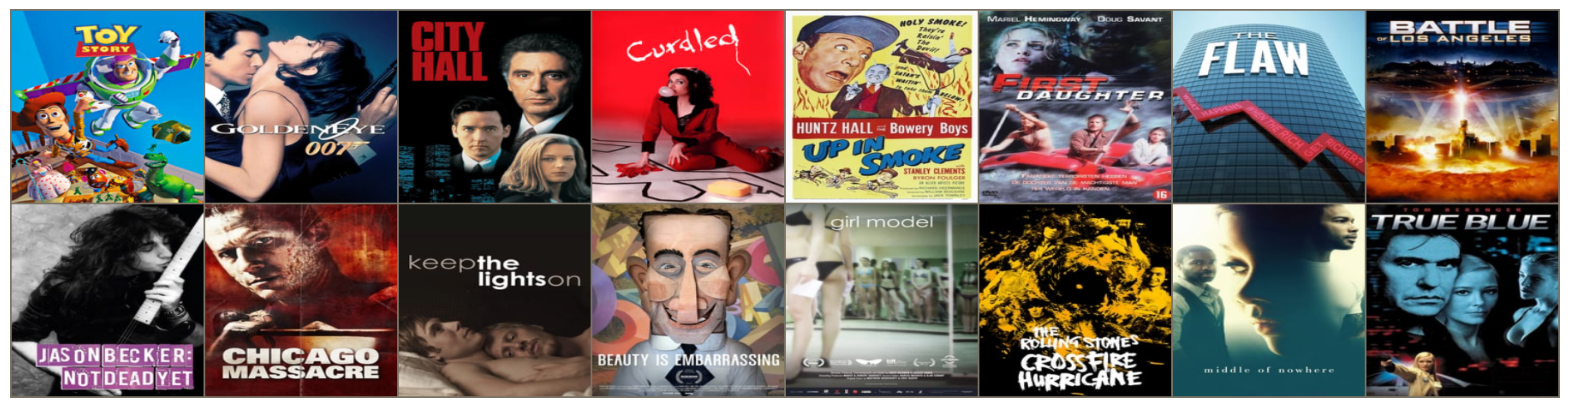

In [39]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
x, paths = next(iter(dataloader))
img_grid = make_grid(x[:16])
img_grid = inv_normalize(img_grid)
plt.figure(figsize=(20,15))
plt.imshow(img_grid.permute(1, 2, 0))
plt.axis('off')

Instantiate a pre-trained a mobilenet_v3_small model (documentation [here](https://pytorch.org/vision/stable/models.html))

In [40]:
import torchvision.models as models
mobilenet = models.mobilenet_v3_small(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 112MB/s]


Have a look to the model:

In [41]:
mobilenet

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

We will now crate a subset of this model to extract the features.
Use a Sequential model to get only the features followed by the avgpool layer of mobilnet and finish with a Flatten layer (```torch.nn.Flatten()```)


In [42]:
model = torch.nn.Sequential(
    mobilenet.features,
    mobilenet.avgpool,
    torch.nn.Flatten()
).cuda()

If your model is OK, it should predict 576-dimensional vectors.

In [43]:
import torch
x = torch.zeros(100, 3, 224,224).cuda()
y = model(x)
y.shape

torch.Size([100, 576])


We will proceed to establish a dataframe containing our extracted features, along with the file paths to the poster images..

In [44]:
import pandas as pd
from tqdm.notebook import tqdm

features_list = []
paths_list = []

for x, paths in tqdm(dataloader):
    with torch.no_grad():
        embeddings = model(x.cuda())
        features_list.extend(embeddings.cpu().numpy())
        paths_list.extend(paths)

df = pd.DataFrame({
    'features': features_list,
    'path': paths_list
})

df.head()

  0%|          | 0/211 [00:00<?, ?it/s]

features  \
0  [0.8096413, 0.24100101, 0.3772409, 0.24335034,...   
1  [0.39853618, 1.143598, 0.61153555, 0.30507135,...   
2  [0.30924132, -0.0037501296, -0.024863252, 0.42...   
3  [0.10391173, 0.42122567, 0.66153115, 0.0102563...   
4  [0.3801082, -0.029013662, 0.25245756, 0.431326...   

                         path  
0       MLP-20M/MLP-20M/1.jpg  
1      MLP-20M/MLP-20M/10.jpg  
2     MLP-20M/MLP-20M/100.jpg  
3    MLP-20M/MLP-20M/1000.jpg  
4  MLP-20M/MLP-20M/100003.jpg

We will now extract all the features into a numpy array that will be used to compute the similarity matrix.

In [45]:
import numpy as np
features = np.vstack(features_list)
features.shape

(26938, 576)

Now compute the cosine similarities between the embeddings of your movies.

In [46]:
from sklearn.metrics.pairwise import cosine_distances
cosine_sim = cosine_distances(features)
cosine_sim.shape

(26938, 26938)

The ```plot_image``` function  displays a poster according to it's path.  
Fill the ```plot_images``` function to plot a series of posters from a list of paths.

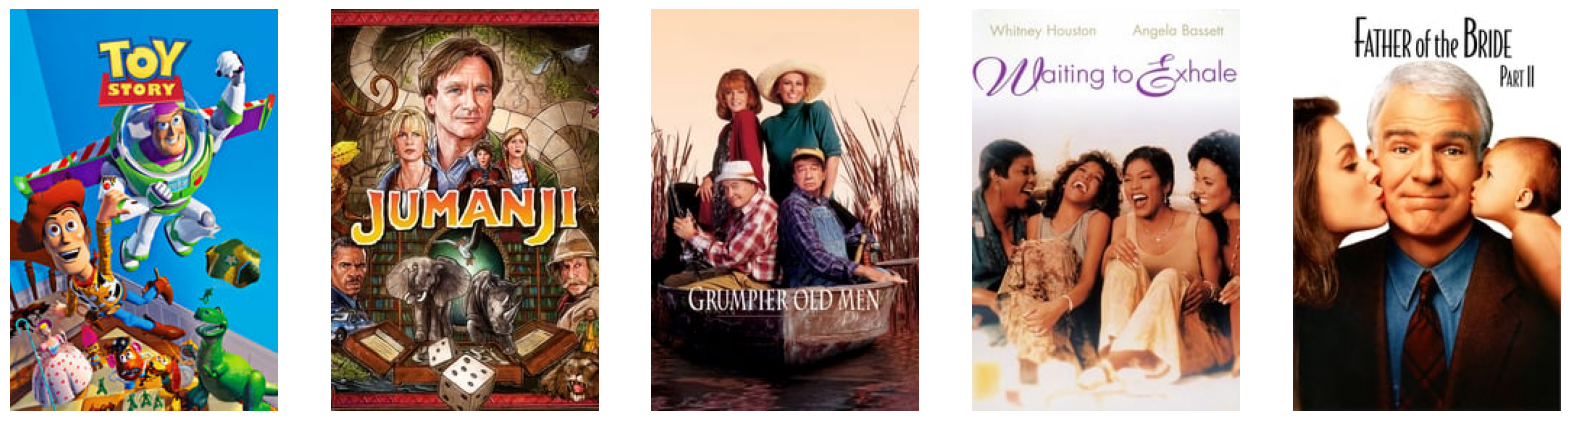

In [47]:
import matplotlib.image as mpimg

def plot_image(path):
  img = mpimg.imread(path)
  plt.imshow(img)
  plt.axis('off')

def plot_images(paths_list):
  n = len(paths_list)
  fig, axs = plt.subplots(1, n, figsize=(20,15))
  for i, path in enumerate(paths_list):
    img = mpimg.imread(path)
    axs[i].imshow(img)
    axs[i].axis('off')


plot_images(['MLP-20M/MLP-20M/1.jpg', 'MLP-20M/MLP-20M/2.jpg', 'MLP-20M/MLP-20M/3.jpg', 'MLP-20M/MLP-20M/4.jpg', 'MLP-20M/MLP-20M/5.jpg'])

Fill the following code to implement a function that plots the top 5 recommendations for a movie according to its index.

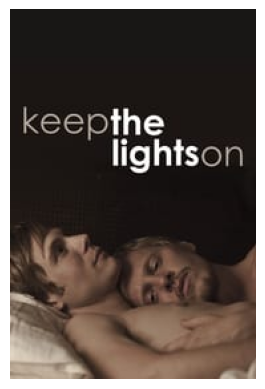

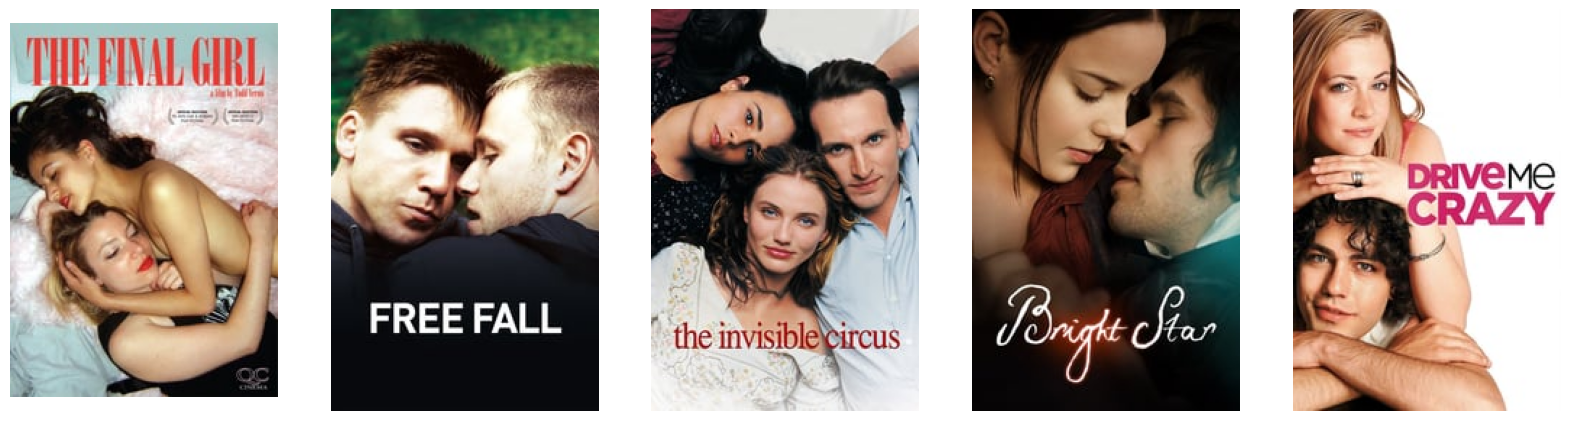

In [52]:
def plot_reco(idx, sim_matrix):
  img = plot_image(df['path'][idx])
  recos = sim_matrix[idx].argsort()[1:6]
  reco_posters = df['path'].iloc[recos]
  plot_images(reco_posters)

idx = 10 #16 #200
plot_reco(idx, cosine_sim)

Try with different movie indexes, you will be surprised by the lack of originality of the poster designers!  
Look at [this post](https://thechive.com/2020/01/20/all-movie-posters-look-the-same-what-the-hell-is-this-sht-20-photos/) to convince yourself.

## Vector databases  

Computing the similarity matrix is a very expensive operation in terms of memory and computation time that scales quadratically with the number of items.  It is also not very practical to store this matrix in a database.  
Vector databases offer a suite of advantages tailored to the needs of modern data analytics and machine learning applications. At their core, they specialize in handling high-dimensional data, allowing for efficient similarity searches—something traditional databases struggle with. This makes them invaluable for tasks like recommendation systems, image searches, and semantic text retrieval. Beyond search efficiency, vector databases are designed for scalability, capable of handling billions of vectors without a hitch. Furthermore, they often come with built-in mechanisms for distributed storage and computation, ensuring data resilience and fast query speeds even as data volumes grow. In essence, vector databases are the backbone that empowers many of the AI-driven solutions we see today.  
For our current session, we're aiming for simplicity and efficiency. Many of the standard vector databases, like [Milvus](https://milvus.io/) or [Weaviate](https://weaviate.io/), require their own dedicated installations and often need to run on separate servers or containers.  
This can introduce added complexity. Instead, we're turning to [Annoy](https://github.com/spotify/annoy) a straightforward library developped by Spotify that lets us perform efficient neighbor searches without the installation and server overhead. While Annoy is great for our present needs, do keep in mind that in larger, production scenarios, the capabilities of a dedicated vector database could be invaluable.

In [53]:
!pip install annoy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 16.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for annoy: filename=annoy-1.17.3-cp311-cp311-linux_x86_64.whl size=553319 sha256=b3fe61dcb7404d5648bb4d20675920591ab2a12e59173c64d2b9e5d879971423
  Stored in directory: /root/.cache/pip/wheels/33/e5/58/0a3e34b92bedf09b4c57e37a63ff395ade6f6c1099ba59877c
Successfully built annoy


We will thus use the annoy library to create a vector database with our features.  
In our case the database will be a simple file on the disk that we will load in memory when needed.
To create the database, we will use an AnnoyIndex with the same dimensionality as our features and a metric to compute the distance between vectors.  
Here we will use the cosine distance and set the database vector size to 576 (the size of our features).

In [54]:
from annoy import AnnoyIndex

dim = 576
annoy_index = AnnoyIndex(dim, 'angular')

We will now fill the database with our features as indexed vectors.

In [55]:
for i, embedding in enumerate(features_list):
    annoy_index.add_item(i, embedding)

annoy_index.build(10)

True

The `annoy_index.build(10)` command builds the underlying data structures required for Annoy to perform its approximate nearest neighbor searches. Specifically, the number 10 indicates that Annoy should construct 10 trees. Building multiple trees helps improve the accuracy of the search at the expense of using more memory. In essence, this command is preparing Annoy to efficiently handle future queries.

Vector databases excel at efficient similarity searches due to their foundational design principles. Traditional databases rely on exact matches or predefined indices to retrieve data. In contrast, vector databases operate in the realm of high-dimensional vector spaces. Here, data points (or vectors) that are semantically or contextually similar are often closer in distance. By leveraging algorithms optimized for these spaces, like approximate nearest neighbor (ANN) searches, vector databases quickly identify data points that lie near a query point. This spatial awareness enables them to bypass exhaustive scans and zero in on relevant results, making similarity searches both rapid and precise.
Thus querying the database for the most similar items to a given item is a very fast operation.  
Complete the following function to retrieve the most similar items to a given item.

In [56]:
def search(query_vector, k=5):
    indices = annoy_index.get_nns_by_vector(query_vector, k)
    paths = df['path'].iloc[indices]
    return paths

Use this function to plot the top-k recommendations for a movie.

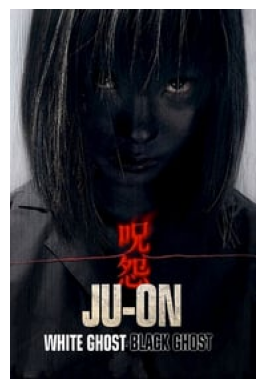

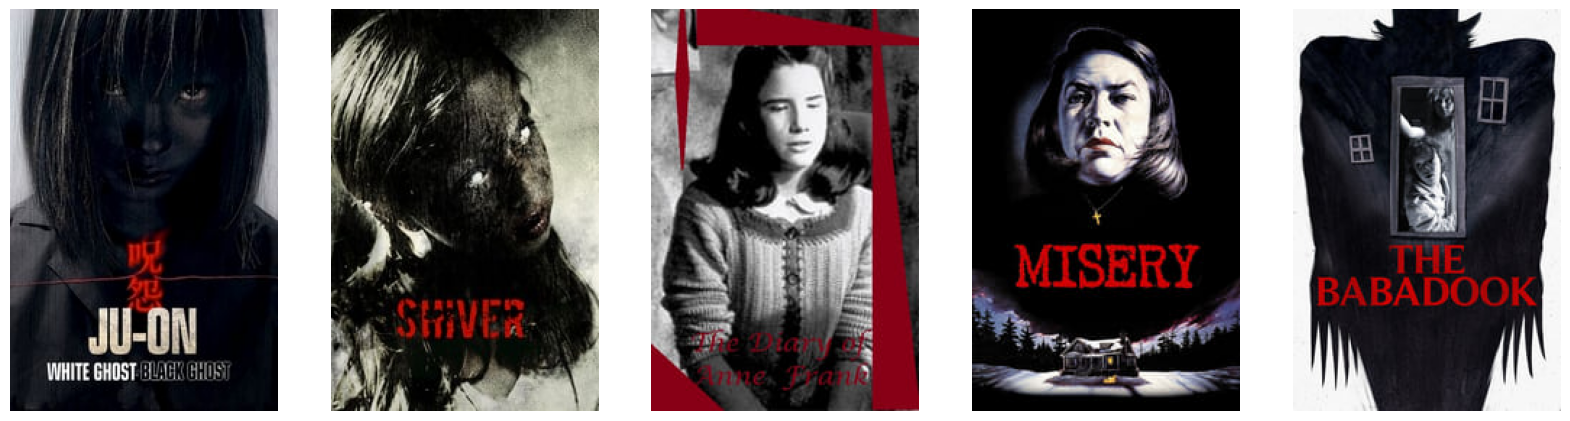

In [62]:
index = 600
plot_image(df.path[index])
query_vector = df.features[index]
result = search(query_vector)
plot_images(result)

Save you database, you will need it for your project.

In [60]:
annoy_index.save('rec_imdb.ann')

True

# Collaborative filtering

### Item-Item

Item-item collaborative filtering, is a form of collaborative filtering for recommender systems based on the similarity between items calculated using people's ratings.
For sake of simplicity, in this practical session, we will only focus on item-item similarity methods.
If you have time, feel free to try an user-item approach. The following [blog post](https://notebook.community/saksham/recommender-systems/Collaborative%20Filtering) may help you to do it.

We will use another dataset containing the ratings of several users on movies.

In [63]:
!wget https://raw.githubusercontent.com/wikistat/AI-Frameworks/master/RecomendationSystem/movielens_small/movies.csv
!wget https://raw.githubusercontent.com/wikistat/AI-Frameworks/master/RecomendationSystem/movielens_small/ratings.csv

--2025-03-11 15:07:31--  https://raw.githubusercontent.com/wikistat/AI-Frameworks/master/RecomendationSystem/movielens_small/movies.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 494431 (483K) [text/plain]
Saving to: ‘movies.csv’

movies.csv          100%[===================>] 482.84K  --.-KB/s    in 0.03s   

2025-03-11 15:07:31 (14.5 MB/s) - ‘movies.csv’ saved [494431/494431]

--2025-03-11 15:07:31--  https://raw.githubusercontent.com/wikistat/AI-Frameworks/master/RecomendationSystem/movielens_small/ratings.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, 

In [64]:
ratings = pd.read_csv('ratings.csv')
ratings = ratings.rename(columns={'movieId':'id'})
ratings['id'] = pd.to_numeric(ratings['id'])
ratings = pd.merge(ratings, metadata[['title', 'id']], on='id')[['userId', 'id', 'rating', 'title']]
ratings.head()

userId    id  rating                 title
0       1   110     1.0     Three Colors: Red
1       1   147     4.5         The 400 Blows
2       1   858     5.0  Sleepless in Seattle
3       1  1246     5.0          Rocky Balboa
4       1  1968     4.0         Fools Rush In

In [68]:
len(pd.unique(ratings['userId']))

265917

In [65]:
ratings.shape

(11437637, 4)

This dataset is a bit huge and may slow down futur computations. Moreover collaborative filtering kind of suffers from products or user with few ratings.
We will only focus on the 100 movies with the most ratings and the users with the highest number of ratings.

In [69]:
# filter movies
ratings['count'] = ratings.groupby('id').transform('count')['userId']
movieId = ratings.drop_duplicates('id').sort_values(
    'count', ascending=False).iloc[:200]['id']
ratings = ratings[ratings['id'].isin(movieId)].reset_index(drop=True)

#filter users
ratings['count'] = ratings.groupby('userId').transform('count')['id']
userId = ratings.drop_duplicates('userId').sort_values(
    'count', ascending=False).iloc[:20001]['userId']
ratings = ratings[ratings['userId'].isin(userId)].reset_index(drop=True)

ratings.shape

(1961101, 5)

In [70]:
ratings.head()

userId  id  rating               title  count
0      24   2     3.0               Ariel     99
1      24   6     4.0      Judgment Night     99
2      24  16     3.0  Dancer in the Dark     99
3      24  17     3.0            The Dark     99
4      24  21     4.0  The Endless Summer     99

In [71]:
ratings.title.unique()[:100]

array(['Ariel', 'Judgment Night', 'Dancer in the Dark', 'The Dark',
       'The Endless Summer', 'Jarhead', '2001: A Space Odyssey',
       'Run Lola Run', 'Three Colors: Red', 'Scarface', 'Stand by Me',
       'The 39 Steps', 'Contempt', 'A River Runs Through It',
       'Terminator 3: Rise of the Machines', 'The Science of Sleep',
       'Grbavica: The Land of My Dreams', 'The Million Dollar Hotel',
       'Monsieur Ibrahim', 'Cockles and Muscles',
       'A Nightmare on Elm Street', 'Aliens vs Predator: Requiem',
       'Romeo + Juliet', 'Sissi', 'Monsoon Wedding', 'The Green Mile',
       'Love Actually', 'Once Were Warriors',
       'The Man with the Golden Arm', 'Dogville', 'Big Fish',
       'Silent Hill', 'The Hours', 'The Conversation', 'Solaris',
       'To Kill a Mockingbird', 'Titanic', 'Men in Black II',
       'Beauty and the Beast', "Monsieur  Hulot's Holiday",
       'Mrs. Doubtfire', 'M', 'Sleepless in Seattle', 'Dawn of the Dead',
       'Arlington Road', 'Point Break

Now, we need to build a pivot table with user in lines, movies in columns and ratings as values.  
Use pandas [pivot_table](https://pandas.pydata.org/docs/reference/api/pandas.pivot_table.html) method to create this pivot table.

In [72]:
pivot = ratings.pivot_table(index='userId', columns='title', values='rating')
pivot.head(100)

title   20,000 Leagues Under the Sea  2001: A Space Odyssey  48 Hrs.  \
userId                                                                 
24                               NaN                    2.0      NaN   
34                               2.5                    NaN      3.5   
46                               2.0                    NaN      4.5   
49                               4.0                    NaN      NaN   
62                               NaN                    3.5      4.5   
...                              ...                    ...      ...   
1126                             NaN                    NaN      2.0   
1136                             NaN                    NaN      5.0   
1145                             NaN                    NaN      3.0   
1149                             NaN                    NaN      4.0   
1155                             NaN                    NaN      3.0   

title   5 Card Stud  A Brief History of Time  A Clockwork Orange  \
userId                                                             
24              NaN                      3.0                 NaN   
34              4.5                      NaN                 NaN   
46              4.0                      4.0                 NaN   
49              5.0                      NaN                 4.0   
62              4.0                      NaN                 4.5   
...             ...                      ...                 ...   
1126            NaN                      1.5                 2.5   
1136            5.0                      NaN                 NaN   
1145            3.5                      NaN                 NaN   
1149            NaN                      NaN                 3.0   
1155            5.0                      NaN                 NaN   

title   A Nightmare on Elm Street  A River Runs Through It  \
userId                                                       
24                            4.0                      4.0   
34                            3.0                      5.0   
46                            4.0                      NaN   
49                            4.0                      5.0   
62                            4.0                      NaN   
...                           ...                      ...   
1126                          NaN                      NaN   
1136                          3.0                      3.5   
1145                          3.0                      5.0   
1149                          5.0                      NaN   
1155                          2.0                      NaN   

title   Aguirre: The Wrath of God  Aliens vs Predator: Requiem  ...  \
userId                                                          ...   
24                            4.0                          2.0  ...   
34                            4.0                          NaN  ...   
46                            NaN                          4.0  ...   
49                            5.0                          NaN  ...   
62                            4.5                          NaN  ...   
...                           ...                          ...  ...   
1126                          NaN                          NaN  ...   
1136                          3.0                          3.0  ...   
1145                          4.0                          NaN  ...   
1149                          3.0                          NaN  ...   
1155                          NaN                          NaN  ...   

title   Wag the Dog  Waiter  We Own the Night  When Saturday Comes  \
userId                                                               
24              NaN     NaN               3.0                  NaN   
34              NaN     NaN               NaN                  NaN   
46              4.5     NaN               NaN                  3.5   
49              NaN     5.0               4.0                  NaN   
62              2.5     3.5

With this pivot table, it is now easy to compute the similarity between movies.
Indeed each movie can be represented by a vector of the users' ratings.
Instead of using a cosine similarity distance as we did earlier in the notebook, we will use the Pearson correlation score since it is already implemented in Pandas.
The pivot table has a method [```corrwith```](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corrwith.html) that will return the Pairwise correlation score of one entry with all entries of the table.

In [76]:
movie_vector = pivot["Titanic"]
similarity = pivot.corrwith(movie_vector)
similarity.sort_values(ascending=False).head(10)

title
Titanic                      1.000000
Big Fish                     0.498388
Psycho                       0.474389
Reservoir Dogs               0.453434
Ringu                        0.449715
Four Rooms                   0.428143
Night on Earth               0.423975
A Clockwork Orange           0.419825
Knockin' on Heaven's Door    0.412543
When Saturday Comes          0.410635
dtype: float64

Sort the produced results to get the best recommendations to "Titanic".
You may also try with different movies.

## Matrix factorization
Matrix factorization is certainly one of the most efficient way to build a recomender system. I really encourage you to have a look to [this article](https://datajobs.com/data-science-repo/Recommender-Systems-%5BNetflix%5D.pdf) presenting the matrix factorization techniques used in recommender systems.

The idea is pretty simple, it consists in factorizing the ratings matrix $R$ into the product of a user embedding matrix $U$ and an item embedding matrix $V$, such that $R \approx UV^\top$ with
$U = \begin{bmatrix} u_{1} \\ \hline \vdots \\ \hline u_{N} \end{bmatrix}$ and
$V = \begin{bmatrix} v_{1} \\ \hline \vdots \\ \hline v_{M} \end{bmatrix}$.

Where
- $N$ is the number of users,
- $M$ is the number of items,
- $R_{ij}$ is the rating of the $j$th item by the $i$th user,
- each row $U_i$ is a $d$-dimensional vector (embedding) representing user $i$,
- each row $V_j$ is a $d$-dimensional vector (embedding) representing item $j$,


One these emmbeding matrices are built, predicting the rating of an user $i$ for an item $j$ consists in computing the dot product $\langle U_i, V_j \rangle$.

### Using surpise

![](https://drive.google.com/uc?export=view&id=1dh2RJ95F0j-rZyuf59G35239B42veAWD)

We will begin by using the famous Singular Value Decomposition method.
Several libraries implement this algorithm.
In this session, we will be using [Surprise](http://surpriselib.com/).
Surprise is a recommender system library implemented in Python.
It was actually developed by [Nicolas Hug](http://nicolas-hug.com/about) an INSA Toulouse Alumni!

In [77]:
!pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 6.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp311-cp311-linux_x86_64.whl size=2505173 sha256=3aad9f88eaf5112eb14e6bcd1f17e481e110dc0ac9854e5897fad6d832fb5b60
  Stored in directory: /root/.cache/pip/wheels/2a/8f/6e/7e2899163e2d85d8266daab4aa1cdabec7a6c56f83c015b5af
Successfully built scikit-surprise


Surprise implements the SVD algorithm.  Help yourself with [the doc](https://surprise.readthedocs.io/en/stable/getting_started.html) to train an SVD model on the rating dataset.

In [78]:
#Creating a train and a test set
testset = ratings.sample(frac=0.1, replace=False)
trainset = ratings[~ratings.index.isin(testset.index)]

assert set(testset.userId.unique()).issubset(trainset.userId.unique())
assert set(testset.id.unique()).issubset(trainset.id.unique())

In [79]:
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate

In [80]:
reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(ratings[['userId', 'id', 'rating']].fillna(0), reader)
svd = SVD()

# Run 5-fold cross-validation and print results.
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)



Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.7559  0.7555  0.7558  0.7559  0.7566  0.7559  0.0004  
MAE (testset)     0.5767  0.5757  0.5757  0.5758  0.5759  0.5760  0.0004  
Fit time          23.60   24.90   24.31   23.99   33.13   25.99   3.60    
Test time         3.27    3.91    3.22    3.50    7.74    4.33    1.72    


{'test_rmse': array([0.75592016, 0.75545134, 0.7557837 , 0.75587085, 0.75656294]),
 'test_mae': array([0.57669855, 0.57567978, 0.57573424, 0.57583875, 0.57592252]),
 'fit_time': (23.602295875549316,
  24.899940967559814,
  24.313004732131958,
  23.985511302947998,
  33.13208746910095),
 'test_time': (3.266801118850708,
  3.90812349319458,
  3.216649055480957,
  3.4970686435699463,
  7.740837335586548)}

In [81]:
#full dataset training
svd = SVD()
s_trainset = data.build_full_trainset()
svd.fit(s_trainset)

Let us look some ratings for one user in the test dataset.

In [82]:
testset[testset['userId'] == 24]

userId    id  rating                            title  count
9       24   111     5.0                         Scarface     99
36      24   597     3.0                          Titanic     99
38      24   648     3.0             Beauty and the Beast     99
66      24  1923     4.0    Twin Peaks: Fire Walk with Me     99
76      24  2054     3.0               Mr. Holland's Opus     99
46      24  1090     5.0             The Thirteenth Floor     99
62      24  1653     4.0           The Motorcycle Diaries     99
29      24   553     4.0                         Dogville     99
16      24   317     3.0  Grbavica: The Land of My Dreams     99
33      24   592     4.0                 The Conversation     99
35      24   595     4.0            To Kill a Mockingbird     99
88      24  2692     4.0                    The Red Elvis     99
85      24  2640     4.0                         Heathers     99
91      24  2959     4.0                   License to Wed     99

What would your model predict for these exemples?

In [104]:
uid = 24
iid = 111

pred = svd.predict(uid, iid)
print(pred)

user: 24         item: 111        r_ui = None   est = 4.69   {'was_impossible': False}


Write a code to recommend 5 movies to an user.

In [110]:
def recommend_movies(user_id, n=5):
  indices = ratings['id'].unique()
  scores = []
  for i in indices:
    score = svd.predict(user_id, i).est
    scores.append([score, i])

  scores = np.array(scores)
  scores = scores[scores[:,0].argsort()]

  max_indices = scores[-n:][:,1]

  titles = []
  for k in max_indices:
    titles.append(ratings[ratings['id'] == k]['title'].unique())
    titles.append([titles, scores[scores[:,1] == k][0][0]])

  titles = pd.DataFrame(titles, columns=['title', 'score'])

  return titles


In [111]:
recommend_movies(24)

title     score
0                            The Talented Mr. Ripley       NaN
1  [[The Talented Mr. Ripley], [[['The Talented M...  4.723393
2                                       The 39 Steps       NaN
3  [[The Talented Mr. Ripley], [[['The Talented M...  4.753485
4                                            Solaris       NaN
5  [[The Talented Mr. Ripley], [[['The Talented M...  4.760796
6                 Terminator 3: Rise of the Machines       NaN
7  [[The Talented Mr. Ripley], [[['The Talented M...  4.981399
8                               Sleepless in Seattle       NaN
9  [[The Talented Mr. Ripley], [[['The Talented M...  5.000000

### Using gradient descent
Another way to compute the matrix factorization consists in using gradient descent to minimize $\text{MSE}(R, UV^\top)$ where:

$$
\begin{align*}
\text{MSE}(A, UV^\top)
&= \frac{1}{|\Omega|}\sum_{(i, j) \in\Omega}{( R_{ij} - (UV^\top)_{ij})^2} \\
&= \frac{1}{|\Omega|}\sum_{(i, j) \in\Omega}{( R_{ij} - \langle U_i, V_j\rangle)^2}
\end{align*}
$$
where $\Omega$ is the set of observed ratings, and $|\Omega|$ is the cardinality of $\Omega$.

We will now implement our own matrix factorization algorith using Pytorch.  
To do so we first need to convert our ratings datasets in Pytorch datasets.

In [113]:
import torch
from torch.utils.data import Dataset, DataLoader

user_list = trainset.userId.unique()
item_list = trainset.id.unique()
user2id = {w: i for i, w in enumerate(user_list)}
item2id = {w: i for i, w in enumerate(item_list)}

class Ratings_Datset(Dataset):
    def __init__(self, df):
        self.df = df.reset_index()

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        user = user2id[self.df['userId'][idx]]
        user = torch.tensor(user, dtype=torch.long)
        item = item2id[self.df['id'][idx]]
        item = torch.tensor(item, dtype=torch.long)
        rating = torch.tensor(self.df['rating'][idx], dtype=torch.float)
        return user, item, rating


trainloader = DataLoader(Ratings_Datset(trainset), batch_size=512, shuffle=True ,num_workers=2)
testloader = DataLoader(Ratings_Datset(testset), batch_size=64, num_workers=2)

These dataloader will provide mini-batches of tuples <user, movie, rating>.
We will use a special type of Pytorch layers call [Embedding](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html).
These layers will create a mapping between an index and a vector representation.
In our case they will provide vector representations of our users and items.
We will train the matrix factorization model to minimize the prediction error between a rating and the dot product of an user embedding with a movie embedding.
![](https://drive.google.com/uc?export=view&id=1wSQbcSN_I28mF74-wnb8_qjAzRH9YDjA)

Complete the following code to implement the ```MatrixFactorization``` class in Pytorch.

In [116]:
pivot.shape

(20001, 198)

In [129]:
import torch

class MatrixFactorization(torch.nn.Module):
    def __init__(self, n_users, n_items, n_factors=20):
        super().__init__()
        self.user_embeddings = torch.nn.Embedding(n_users, n_factors)
        self.item_embeddings = torch.nn.Embedding(n_items, n_factors)

    def forward(self, user, item):
        return torch.mul(self.user_embeddings(user), self.item_embeddings(item)).sum(1)
        #return (self.user_embeddings(user)*self.item_embeddings(item)).sum(1)

Complete the training method that we will use to train the network.

In [130]:
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
from statistics import mean


def train(model, optimizer, trainloader, epochs=30):
    criterion = nn.MSELoss(reduction='mean')
    t = tqdm(range(epochs))
    for epoch in t:
        total = 0
        train_loss = []
        for users, items, r in trainloader:
            users = users.cuda()
            items = items.cuda()
            r = r.cuda() / 5
            r = r.unsqueeze(1)
            y_hat = model(users,items)
            loss = criterion(y_hat, r)

            train_loss.append(loss.item())
            total += r.size(0)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            t.set_description(f"loss: {mean(train_loss)}")

We now have everything to train our model.
Train your model for 5 to 10 epochs.

In [131]:
n_user = trainset.userId.nunique()
n_items = trainset.id.nunique()
model = MatrixFactorization(n_user, n_items).cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
train(model, optimizer, trainloader, epochs=5)

  0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([512, 1])) that is different to the input size (torch.Size([512])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([127, 1])) that is different to the input size (torch.Size([127])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Complete the following code to evaluate your model.

In [133]:
import math

def test(model, testloader):


    running_mae = 0
    with torch.no_grad():
        total = 0
        for users, items, r in testloader:
            users = users.cuda()
            items = items.cuda()
            y = r.cuda() / 5
            y_hat = model(users, items)
            error = torch.mean(torch.abs(y_hat - y))

            running_mae += error
            total += y.size(0)

    mae = running_mae/total
    return mae * 5


test(model, testloader)

tensor(0.0125, device='cuda:0')

Try to compare the predictions of your model with actual ratings.

In [134]:
users, movies, r = next(iter(testloader))
users = users.cuda()
movies = movies.cuda()
r = r.cuda()

y = model(users, movies)*5
print("ratings", r[:10].data)
print("predictions:", y.flatten()[:10].data)

ratings tensor([3., 3., 4., 1., 5., 5., 3., 2., 2., 3.], device='cuda:0')
predictions: tensor([3.5372, 3.5765, 3.5080, 3.6077, 3.6615, 3.6575, 3.5680, 3.5455, 3.5781,
        3.5867], device='cuda:0')


We just trained a matrix factorization algorithm using Pytorch.
In this setting, the final prediction was made with the dot product of our embeddings.
Actually with a minimal modification of the Class, we could create a full neural network.
If we replace the dot product with a fully-connected network, we would actually have an end-to-end neural network able to predict the ratings of our users.
![](https://drive.google.com/uc?export=view&id=1THBMB-Z3db0Rn0dyYYWhN98AHcYEM-nT)  
This approach is called Neural Collaborative Filtering and is presented in this [paper](https://arxiv.org/pdf/1708.05031.pdf).
Try to fill in the following code to create an NCF network.



In [135]:
class NCF(nn.Module):

    def __init__(self, n_users, n_items, n_factors=8):
        super().__init__()
        self.user_embeddings = torch.nn.Embedding(n_users, n_factors)
        self.item_embeddings = torch.nn.Embedding(n_items, n_factors)
        self.predictor = torch.nn.Sequential(
            nn.Linear(n_factors*2, n_factors),
            nn.ReLU(),
            nn.Linear(n_factors, 1),
            nn.Sigmoid()
        )


    def forward(self, user, item):


        u = self.user_embeddings(user)
        i = self.item_embeddings(item)

        # Concat the two embedding layers
        z = torch.cat([u, i], dim=-1)
        return self.predictor(z)

Train your NCF network on the train dataset and test it on the test dataset.

In [136]:
model = NCF(n_user, n_items).cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
train(model, optimizer, trainloader, epochs=5)

  0%|          | 0/5 [00:00<?, ?it/s]

In [137]:
test(model, testloader)

tensor(0.0142, device='cuda:0')

In [138]:
users, movies, r = next(iter(testloader))
users = users.cuda()
movies = movies.cuda()
r = r.cuda()

y = model(users, movies)*5
print("ratings", r[:10].data)
print("predictions:", y.flatten()[:10].data)

ratings tensor([3., 3., 4., 1., 5., 5., 3., 2., 2., 3.], device='cuda:0')
predictions: tensor([2.3695, 3.3801, 3.8388, 2.7821, 3.8042, 4.5011, 3.5328, 3.5119, 2.6947,
        3.3637], device='cuda:0')


### Implicit feedback with pytorch

In this practical session, we only worked with explicit feedbacks (ratings).
Sometimes you do not have access to such quantitative feedback and have to deal with implicit feedback.
An implicit feedback is a user's qualitative interaction with an item, such as clicking on an item (positive feedback) or stopping watching a video (negative feedback).
If you are interested in neural collaborative filtering in the case of implicit feedback, I recommend you look at this [excellent tutorial](https://sparsh-ai.github.io/rec-tutorials/matrixfactorization%20movielens%20pytorch%20scratch/2021/04/21/rec-algo-ncf-pytorch-pyy0715.html).